# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [161]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [162]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import warnings
from datetime import datetime
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [163]:
warnings.filterwarnings("ignore", category=FutureWarning)
symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
if symbol_list:
    build_new_dataset = True
else:
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6
hidden_layers = ast.literal_eval(f"({input('Hidden Layers: eg. "100, 100"')})")
if hidden_layers:
    train_new_model = True
    verticle_jobs = 1 #'-1' for max
if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

## Data Preparation

In [164]:
symbols = []
if symbol_list == 'filtered':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = np.random.choice(all_symbols, num_symbols, replace=False).tolist()
    symbols = symbols + pd.read_csv("../data/filtered_tickers.csv")["Ticker"].tolist()

symbols = symbols + pd.read_csv('../data/simple_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['AA', 'AAT', 'ABR', ..., 'WB', 'SYDB.CO', 'COLO-B.CO'],
      dtype=object)

#### Download annual financial data

In [165]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv('../data/filtered_tickers.csv')
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Name': ticker.info["displayName"], 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan
            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'
            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]
            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]
            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]
            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            if len(earning_dates) == 5:
                earning_dates.remove(earning_dates[4])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f"{symbol} had {len(earning_dates)} earning dates, not 5")
                continue
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Name': ticker.info["displayName"], 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'
                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]
                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]
                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 4:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because the length of the df was not 4, it was {len(ticker_df)}')
                continue

            if ticker_df.isna().sum().sum() < round(352 * minimum_feature_threshold):
                if symbol not in filtered_pd['Ticker'].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{'Ticker': symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(['Ticker', 'Name', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                    if debugging:
                        print(f'Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(352 * minimum_feature_threshold)}')
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd['Ticker'].tolist():
                filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because an exception was raised')
                    print(error)
            continue
    filtered_pd.to_csv('../data/filtered_tickers.csv', index=False)
    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [166]:
if debugging:
    display(df)

,Ticker,Name,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Net Income Extraordinary,Restricted Common Stock,Dividends Paid Direct,Depletion Income Statement,Net Income From Tax Loss Carryforward
0,AA,Alcoa,2025-03-31,NaN,NaN,NaN,Basic Materials,Aluminum,-1.800000e+07,-2.166667e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AA,Alcoa,2023-12-31,-0.018451,0.130405,0.123098,Basic Materials,Aluminum,-4.400000e+08,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AA,Alcoa,2022-12-31,-0.062309,-0.250328,-0.243344,Basic Materials,Aluminum,3.420000e+08,-5.000000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AA,Alcoa,2021-12-31,0.522660,-0.246283,-0.231174,Basic Materials,Aluminum,5.300000e+08,-1.500000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAT,American Assets Trust,2025-03-31,NaN,NaN,NaN,Real Estate,REIT - Diversified,2.042400e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6247,IQ,iQIYI,2021-12-31,0.048246,-0.041667,0.162281,Communication Services,Entertainment,-6.352582e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6248,UBER,Uber,2025-03-31,NaN,NaN,NaN,Technology,Software - Application,2.250000e+09,-1.785000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6249,UBER,Uber,2023-12-31,0.219354,0.114032,-0.025024,Technology,Software - Application,3.362000e+09,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6250,UBER,Uber,2022-12-31,0.281844,0.745653,1.489689,Technology,Software - Application,3.900000e+08,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [167]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Name', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [168]:
pred_data = pd.DataFrame()
train_data = pd.DataFrame()
for i in range(int(len(df) / 4)):
    pred_data = pd.concat([pred_data, df.iloc[[i*4]]]) 
    train_data = pd.concat([train_data, df.iloc[[1+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*4]]])
if debugging:
    print('Prediction Data:')
    display(pred_data)
    print('Train and Test Data:')
    display(train_data)

Prediction Data:


,Ticker,Name,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Net Income Extraordinary,Restricted Common Stock,Dividends Paid Direct,Depletion Income Statement,Net Income From Tax Loss Carryforward
0,AA,Alcoa,2025-03-31,NaN,NaN,NaN,0,5,-0.005043,5.445762e-02,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
4,AAT,American Assets Trust,2025-03-31,NaN,NaN,NaN,8,95,-0.004977,-8.948276e-18,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
8,ABR,Arbor Realty Trust,2025-03-31,NaN,NaN,NaN,8,99,-0.004754,6.604806e-02,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
12,ACI,Albertsons Companies,2025-02-28,NaN,NaN,NaN,3,54,-0.004542,7.072139e-02,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
16,ACRE,Ares Commercial Real Estate,2025-03-31,NaN,NaN,NaN,8,99,-0.004998,7.060630e-02,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6232,PDD,PDD,2025-03-31,NaN,NaN,NaN,2,69,0.021589,-8.948276e-18,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
6236,BIDU,Baidu,2025-03-31,NaN,NaN,NaN,1,68,-0.015300,-2.863310e-01,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
6240,NTES,NetEase,2025-03-31,NaN,NaN,NaN,1,41,0.014452,4.793201e-02,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
6244,IQ,iQIYI,2025-03-31,NaN,NaN,NaN,1,44,-0.004431,-8.948276e-18,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0


Train and Test Data:


,Ticker,Name,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Net Income Extraordinary,Restricted Common Stock,Dividends Paid Direct,Depletion Income Statement,Net Income From Tax Loss Carryforward
1,AA,Alcoa,2023-12-31,-0.018451,0.130405,0.123098,0,5,-0.005766,7.072139e-02,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
2,AA,Alcoa,2022-12-31,-0.062309,-0.250328,-0.243344,0,5,-0.004426,3.318960e-02,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
3,AA,Alcoa,2021-12-31,0.522660,-0.246283,-0.231174,0,5,-0.004103,5.946186e-02,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
5,AAT,American Assets Trust,2023-12-31,-0.031142,-0.031311,0.220023,8,95,-0.004831,-8.948276e-18,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
6,AAT,American Assets Trust,2022-12-31,-0.288542,-0.252711,-0.095800,8,95,-0.004900,-8.948276e-18,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6246,IQ,iQIYI,2022-12-31,0.373585,0.007547,-0.079245,1,44,-0.005595,-8.948276e-18,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
6247,IQ,iQIYI,2021-12-31,0.048246,-0.041667,0.162281,1,44,-0.015902,-8.948276e-18,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
6249,UBER,Uber,2023-12-31,0.219354,0.114032,-0.025024,9,118,0.000752,7.072139e-02,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
6250,UBER,Uber,2022-12-31,0.281844,0.745653,1.489689,9,118,-0.004343,7.072139e-02,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0


### Labeling

In [169]:
ignore_columns = ["Ticker", "Name", "Sector", "Industry", "Date", '3M Future Change', '6M Future Change', '1Y Future Change']
X_pred = pred_data.drop(ignore_columns, axis=1)
X_train = train_data.drop(ignore_columns, axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

if debugging:
    print("X_train:")
    display(X_train)
    print("y_train:")
    display(y_train)
    print("X_test:")
    display(X_test)
    print("y_test:")
    display(y_test)

X_train:


,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,Effect Of Exchange Rate Changes,Changes In Cash,Financing Cash Flow,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Net Income Extraordinary,Restricted Common Stock,Dividends Paid Direct,Depletion Income Statement,Net Income From Tax Loss Carryforward
2702,-0.005127,7.072139e-02,0.040214,-0.038769,0.049138,-0.054555,-0.056336,-2.760882e-02,-0.031430,-0.021134,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
1419,-0.004926,7.040673e-02,0.040283,-0.038890,0.049328,-0.054399,-0.056188,-2.748532e-02,-0.031354,-0.021282,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
233,-0.004755,6.067789e-02,0.040234,-0.038870,0.049124,-0.054517,-0.056268,-2.755932e-02,-0.031576,-0.021696,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
6237,0.038395,-2.868815e-01,0.026763,-0.031365,0.015119,-0.026169,-0.001493,-2.472550e-02,-0.147136,-0.044347,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
5561,-0.005099,6.997376e-02,0.040273,-0.038890,0.049229,-0.054547,-0.056308,-2.756232e-02,-0.031539,-0.021329,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697,-0.005102,5.442231e-02,0.040053,-0.038861,0.049311,-0.054399,-0.055937,-4.796853e-18,-0.032557,-0.022434,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
4295,-0.004995,-8.948276e-18,0.040282,-0.038883,0.049351,-0.054507,-0.056260,-2.756539e-02,-0.031558,-0.021338,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
5065,-0.004194,4.906983e-02,0.040282,-0.038890,0.049123,-0.054183,-0.055909,-2.753575e-02,-0.031522,-0.021747,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
4201,-0.004882,7.067801e-02,0.039374,-0.038095,0.049373,-0.054521,-0.056322,-4.796853e-18,-0.031329,-0.021488,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0


y_train:


,3M Future Change,6M Future Change,1Y Future Change
2702,0.055431,-0.014036,-0.072432
1419,-0.028715,-0.268072,-0.477309
233,0.254438,0.140850,0.474962
6237,-0.106434,-0.261246,-0.250976
5561,-0.393508,-0.383215,-0.581156
...,...,...,...
5697,0.061056,-0.192839,-0.044297
4295,0.271570,-0.147100,-0.179632
5065,0.295328,-0.161580,-0.125149
4201,-0.063232,-0.073982,0.155315


X_test:


,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,Effect Of Exchange Rate Changes,Changes In Cash,Financing Cash Flow,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Net Income Extraordinary,Restricted Common Stock,Dividends Paid Direct,Depletion Income Statement,Net Income From Tax Loss Carryforward
5734,-0.004791,7.014611e-02,0.040223,-0.038868,0.049374,-0.054470,-0.056238,-4.796853e-18,-0.031462,-0.021439,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
34,-0.004762,5.497455e-02,0.040228,-0.038890,0.048589,-0.054442,-0.055992,-2.757833e-02,-0.032518,-0.021939,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
5029,-0.006288,7.072139e-02,0.038770,-0.037301,0.041036,-0.054267,-0.055561,-4.796853e-18,-0.033684,-0.020709,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
1409,0.000222,6.486643e-02,0.039363,-0.038008,0.047895,0.006468,0.070084,-2.749192e-02,-0.319620,-0.126107,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
3233,-0.004932,6.990080e-02,0.040283,-0.038890,0.049234,-0.054295,-0.056086,-2.755696e-02,-0.031302,-0.021302,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,0.067887,-8.948276e-18,0.038506,-0.037129,-0.052015,-0.016630,-0.022902,-2.703924e-02,0.011477,-0.077972,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
2737,-0.004887,6.809229e-02,0.040278,-0.038679,0.049283,-0.054361,-0.056216,-4.796853e-18,-0.030974,-0.020271,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
3759,0.020295,-1.929770e-01,0.039075,-0.038890,0.047280,-0.047056,-0.046423,-2.697888e-02,-0.039412,-0.040983,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0
3969,-0.005004,7.028880e-02,0.040283,-0.038890,0.049378,-0.054515,-0.056297,-2.755456e-02,-0.031428,-0.021281,...,-6.571367e-15,6.684017e-15,0.0,-3.467766e-15,3.618723e-15,0.0,0.0,0.0,0.0,0.0


y_test:


,3M Future Change,6M Future Change,1Y Future Change
5734,-0.146575,0.215068,0.294521
34,-0.202976,-0.077974,0.287320
5029,0.022472,-0.089399,0.286761
1409,0.072172,0.076043,0.188850
3233,0.035573,-0.268775,-0.355731
...,...,...,...
442,0.068598,0.059911,0.110505
2737,0.262003,0.292455,-0.302469
3759,0.017665,0.017077,-0.157005
3969,-0.181575,0.112150,-0.157543


## Model Training

In [170]:
if train_new_model:
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        learning_rate="adaptive",
        early_stopping=True,
        verbose=True,
        tol=0.00001,
        n_iter_no_change=round(40000/hidden_layers[0])
    )
    print(f"iter_no_change: {model.n_iter_no_change}")
    model.fit(X_train, y_train)

iter_no_change: 20
Iteration 1, loss = 3.09289475
Validation score: -0.012798
Iteration 2, loss = 0.06341497
Validation score: -0.002739
Iteration 3, loss = 0.06288586
Validation score: -0.001074
Iteration 4, loss = 0.06269943
Validation score: -0.001182
Iteration 5, loss = 0.06255693
Validation score: -0.003397
Iteration 6, loss = 0.06253496
Validation score: -0.001547
Iteration 7, loss = 0.06227454
Validation score: -0.014218
Iteration 8, loss = 0.06215802
Validation score: -0.000241
Iteration 9, loss = 0.06156755
Validation score: 0.003364
Iteration 10, loss = 0.06084800
Validation score: -0.003797
Iteration 11, loss = 0.06193202
Validation score: -0.003241
Iteration 12, loss = 0.06176067
Validation score: -0.035773
Iteration 13, loss = 0.06088495
Validation score: -0.028360
Iteration 14, loss = 0.05993200
Validation score: -0.021358
Iteration 15, loss = 0.05854376
Validation score: -0.031824
Iteration 16, loss = 0.05861036
Validation score: -0.007614
Iteration 17, loss = 0.05773968

## Testing and benchmarking

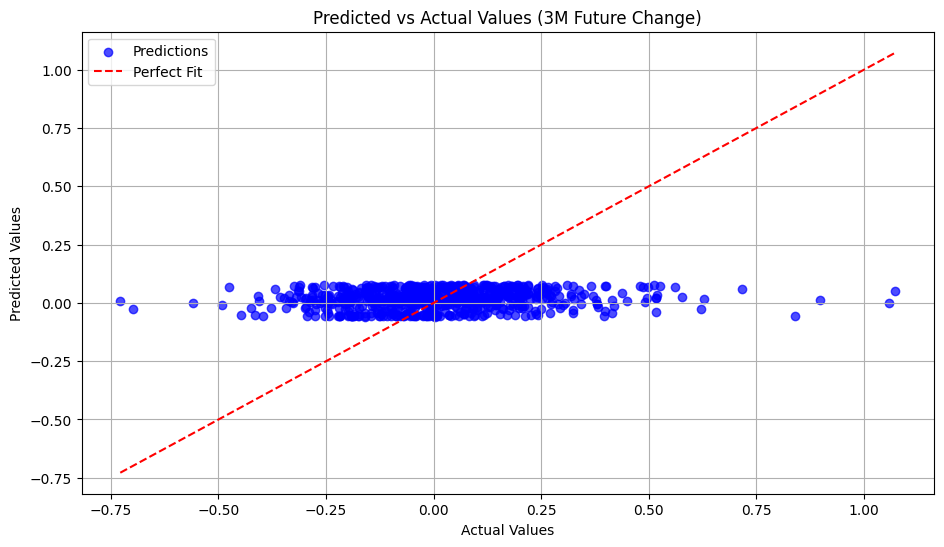

3M Future Change - R²: 0.0137
3M Future Change - MSE: 0.0415
3M Future Change - MAE: 0.1513


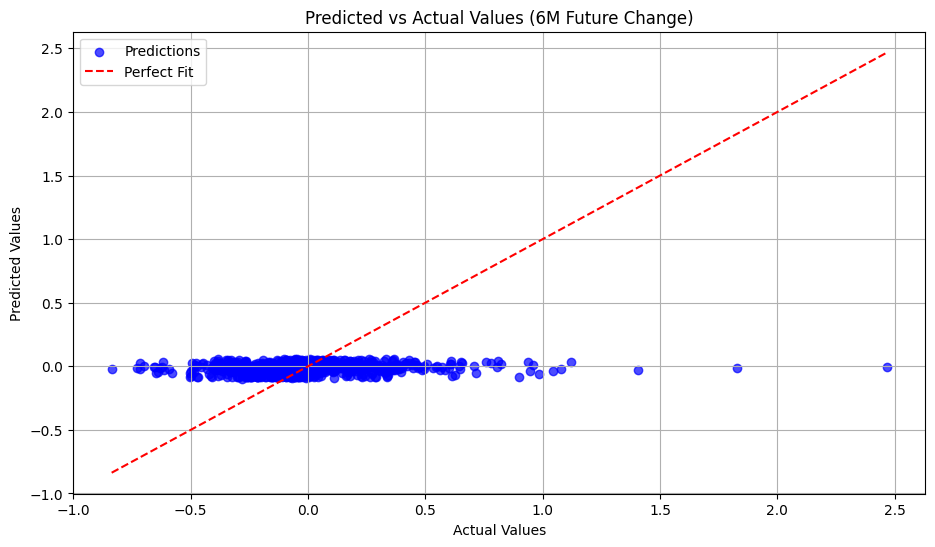

6M Future Change - R²: 0.0160
6M Future Change - MSE: 0.0963
6M Future Change - MAE: 0.2203


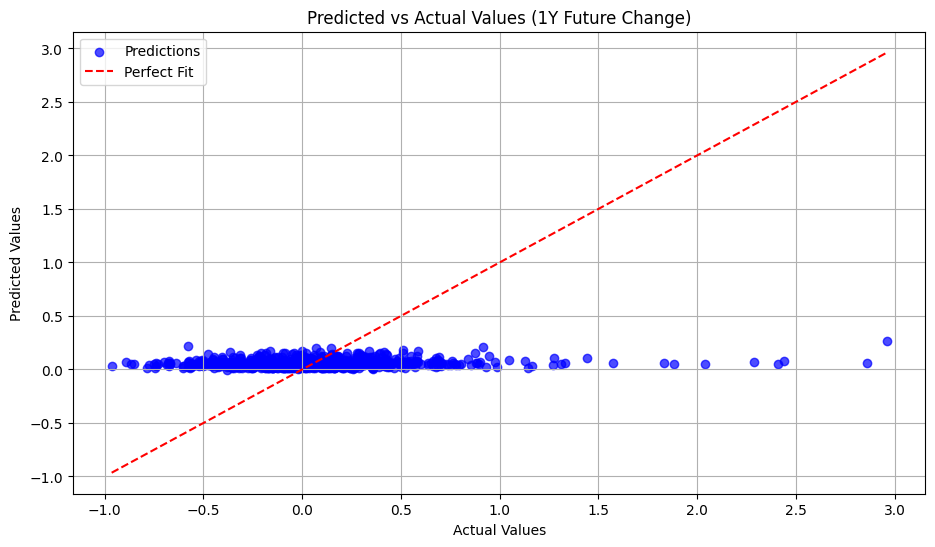

1Y Future Change - R²: 0.0165
1Y Future Change - MSE: 0.2015
1Y Future Change - MAE: 0.3175

Overall Scores:
Mean - R²: 0.0154
Mean - MSE: 0.1131
Mean - MAE: 0.2297


In [171]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
        y_test_actual = y_test[target]
        y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [172]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        'hidden_layer_sizes': [model.hidden_layer_sizes],
        'max_iter': model.max_iter,
        'n_iter_no_change': model.n_iter_no_change,
        'learning_rate': model.learning_rate,
        'learning_rate_init': model.learning_rate_init,
        'batch_size': model.batch_size,
        'tol': model.tol,
        'alpha': model.alpha,
        'shuffle': model.shuffle,
    })
    test_results.to_csv('../data/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../models/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

Old best R²: -0.0081677773957234
New best R²: 0.015404372888430959
Saving new best model...


## Predictions on latest data

In [173]:
best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: 0.0154043728884309


In [174]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_1y) / 3
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

,Ticker,Name,mean (%),3m (%),6m (%),1y (%)
0,AA,Alcoa,5.503213,6.020732,1.897653,8.591255
1,AAT,American Assets Trust,1.976226,1.732389,-1.182927,5.379217
2,ABR,Arbor Realty Trust,2.106407,1.808740,-0.982400,5.492882
3,ACI,Albertsons Companies,3.199143,3.105449,0.075536,6.416444
4,ACRE,Ares Commercial Real Estate,-3.329240,-4.699054,-7.356368,2.067703
...,...,...,...,...,...,...
1558,PDD,PDD,7.389519,7.937408,3.509962,10.721188
1559,BIDU,Baidu,-3.446574,-4.513505,-7.513821,1.687605
1560,NTES,NetEase,9.583103,6.610995,4.674087,17.464228
1561,IQ,iQIYI,-5.918786,-5.214395,-10.454859,-2.087104


In [175]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"The author was stupid and forgot to cover this obvious, famous stock. Try another.", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "")

In [176]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'MATAS.CO'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c04c269c6374abc4a1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
